<a href="https://colab.research.google.com/github/mjkm97/03.-ML-Model-Time-Series-Sales-Prediction/blob/main/ML_Project_(3)Linear_Regression_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# 데이터 경로 지정 및 읽어오기
import pandas as pd

data_path = '/content/train_store.csv'

# Define your column names as a list

custom_column_names = ['Store',
                       'DayOfWeek',
                       'Date',
                       'Year',
                       'Month',
                       'Day',
                       'Sales',
                       'Customers',
                       'Open',
                       'Promo',
                       'StateHoliday',
                       'SchoolHoliday',
                       'StoreType',
                       'Assortment'	,
                       'CompetitionDistance',
                       'CompetitionOpenSinceMonth',
                       'CompetitionOpenSinceYear',
                       'Promo2',
                       'Promo2SinceWeek',
                       'Promo2SinceYear',
                       'PromoInterval']

# Load the CSV with custom column names
df = pd.read_csv(data_path, header=0, names=custom_column_names)

# Print the column names
print(df.columns)

Index(['Store', 'DayOfWeek', 'Date', 'Year', 'Month', 'Day', 'Sales',
       'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


<ipython-input-12-df93fd69130c>:31: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, header=0, names=custom_column_names)


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import numpy as np

seed = 42
np.random.seed(seed)

In [15]:
pd.set_option('future.no_silent_downcasting', True)
df['StateHoliday'] = df['StateHoliday'].replace({'0': 0, 'a': 1, 'b': 1, 'x': 1})

print(df['StoreType'].unique())
print(df['Assortment'].unique())
print(df['StateHoliday'].unique())
print(df['SchoolHoliday'].unique())
print(df['DayOfWeek'].unique())
print(df['Month'].unique())
print(df['Promo'].unique())
print(df['Promo2'].unique())

['c' 'a' 'd' 'b']
['a' 'c' 'b']
[0 1]
[1 0]
[5 4 3 2 1 7 6]
[7 6 5 4]
[1 0]
[ 0.  1. nan]


In [16]:
print(df['StateHoliday'].unique())


[0 1]


In [17]:
df.dtypes

,0
Store,int64
DayOfWeek,int64
Date,object
Year,int64
Month,int64
Day,int64
Sales,int64
Customers,int64
Open,int64
Promo,int64


###원핫인코딩* 사용하여 회귀모델 생성###

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random

# 데이터 로드
train_store = pd.read_csv("/content/train_store.csv")
test = pd.read_csv("/content/test.csv")

# 날짜 정렬 (Store별로 시계열 순서 유지)
train_store.sort_values(['Store', 'Date'], inplace=True)

# 시계열 특성 생성
train_store['Sales_lag_1'] = train_store.groupby('Store')['Sales'].shift(1)
train_store['Sales_lag_7'] = train_store.groupby('Store')['Sales'].shift(7)
train_store['Sales_lag_14'] = train_store.groupby('Store')['Sales'].shift(14)
train_store['Sales_roll_mean_7'] = train_store.groupby('Store')['Sales'].shift(1).rolling(window=7).mean().reset_index(0, drop=True)

# 결측치 제거
train_store.dropna(subset=['Sales_lag_1', 'Sales_lag_7', 'Sales_lag_14',
                           'Sales_roll_mean_7'], inplace=True)
train_store['StateHoliday'] = train_store['StateHoliday'].replace({'0': 0, 'a': 1, 'b': 1, 'c': 1}).astype(int)

# 원핫인코딩 적용(범주형)
categorical_cols = ['StoreType', 'Assortment']
train_store_encoded = pd.get_dummies(train_store, columns=categorical_cols, drop_first=True)

# 정규화할 연속형 변수 정의
continuous_features = ['CompetitionDistance', 'Sales_lag_1', 'Sales_lag_7', 'Sales_lag_14',
                       'Sales_roll_mean_7']

# 정규화 적용
scaler = MinMaxScaler()
train_store_encoded[continuous_features] = scaler.fit_transform(train_store_encoded[continuous_features])

# 특성과 타겟 변수 정의

features = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Promo2',
            'CompetitionDistance',
            'Sales_lag_1', 'Sales_lag_7', 'Sales_lag_14',
            'Sales_roll_mean_7','Day', 'Month', 'Year'
           ]

# 원핫인코딩된 열 이름 추가
features.extend([col for col in train_store_encoded.columns
                if col.startswith(tuple(f'{c}_' for c in categorical_cols))])

# 특성과 타겟 분리
X = train_store_encoded[features]
y = train_store_encoded['Sales']

# RMSPE 함수 정의 (Root Mean Squared Percentage Error)
def rmspe(y_true, y_pred):
    mask = y_true != 0
    y_true= y_true[mask]
    y_pred = y_pred[mask]
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# 전체 훈련 및 검증 세트 분리
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 반복 학습 (10번 반복)
n_iterations = 10
best_mse = float('inf')
best_model = None
models = []
performances = []

for i in range(n_iterations):
    # 다양한 모델 시도
    if i % 3 == 0:
        # 기본 선형 회귀
        model = LinearRegression()
        model_name = "LinearRegression"
    elif i % 3 == 1:
        # Ridge 회귀 (알파값 랜덤)
        alpha = random.uniform(0.1, 10.0)
        model = Ridge(alpha=alpha)
        model_name = f"Ridge(alpha={alpha:.2f})"
    else:
        # Lasso 회귀 (알파값 랜덤)
        alpha = random.uniform(0.001, 1.0)
        model = Lasso(alpha=alpha)
        model_name = f"Lasso(alpha={alpha:.4f})"

    # 부트스트랩 샘플링 (데이터 변형을 위해)
    sample_indices = np.random.choice(len(X_train_full), size=int(0.8*len(X_train_full)), replace=True)
    X_train = X_train_full.iloc[sample_indices]
    y_train = y_train_full.iloc[sample_indices]

    # 모델 학습
    model.fit(X_train, y_train)

    # 모델 평가
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    # 모델 및 성능 저장
    models.append((model, model_name))
    performances.append((mse, rmse, r2))

    # 최고 모델 업데이트
    if mse < best_mse:
        best_mse = mse
        best_model = model
        best_model_name = model_name

    print(f"Iteration {i+1}: {model_name} - MSE = {mse:.4f}, RMSE = {rmse:.2f}, R2 = {r2:.4f}")

# 최고 모델로 훈련 및 검증 세트 예측
print(f"\nBest Model: {best_model_name} (MSE = {best_mse:.4f})")

# 훈련 세트에 대한 성능 평가
y_train_pred = best_model.predict(X_train_full)
train_mae = mean_absolute_error(y_train_full, y_train_pred)
train_mse = mean_squared_error(y_train_full, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_full, y_train_pred)
train_rmspe = rmspe(y_train_full, y_train_pred)

# 검증 세트에 대한 성능 평가
y_val_pred = best_model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)
val_rmspe = rmspe(y_val, y_val_pred)

# 성능 평가 결과 표시
print(f"\n{'Metric':<10} {'Train':>10} {'Test':>10}")
print(f"{'-'*30}")
print(f"{'MAE':<10} {train_mae:>10.2f} {val_mae:>10.2f}")
print(f"{'RMSE':<10} {train_rmse:>10.2f} {val_rmse:>10.2f}")
print(f"{'R2 score':<10} {train_r2:>10.2f} {val_r2:>10.2f}")
print(f"{'RMSPE':<10} {train_rmspe:>10.2f} {val_rmspe:>10.2f}")

<ipython-input-19-882160fe7508>:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_store = pd.read_csv("/content/train_store.csv")


Iteration 1: LinearRegression - MSE = 6655837.2312, RMSE = 2579.89, R2 = 0.5503
Iteration 2: Ridge(alpha=9.44) - MSE = 6656297.2415, RMSE = 2579.98, R2 = 0.5503
Iteration 3: Lasso(alpha=0.1754) - MSE = 6654862.4525, RMSE = 2579.70, R2 = 0.5504
Iteration 4: LinearRegression - MSE = 6655692.6541, RMSE = 2579.86, R2 = 0.5503
Iteration 5: Ridge(alpha=0.90) - MSE = 6654834.5408, RMSE = 2579.70, R2 = 0.5504
Iteration 6: Lasso(alpha=0.0311) - MSE = 6655972.4140, RMSE = 2579.92, R2 = 0.5503
Iteration 7: LinearRegression - MSE = 6656288.0320, RMSE = 2579.98, R2 = 0.5503
Iteration 8: Ridge(alpha=5.09) - MSE = 6655648.8547, RMSE = 2579.85, R2 = 0.5503
Iteration 9: Lasso(alpha=0.4675) - MSE = 6656180.5320, RMSE = 2579.96, R2 = 0.5503
Iteration 10: LinearRegression - MSE = 6655315.6032, RMSE = 2579.79, R2 = 0.5503

Best Model: Ridge(alpha=0.90) (MSE = 6654834.5408)

Metric          Train       Test
------------------------------
MAE           1953.11    1950.23
RMSE          2585.45    2579.70
R2 s

파일 저장 완료: linear_regression_predictions.csv
 R-squared (R²): 0.5504


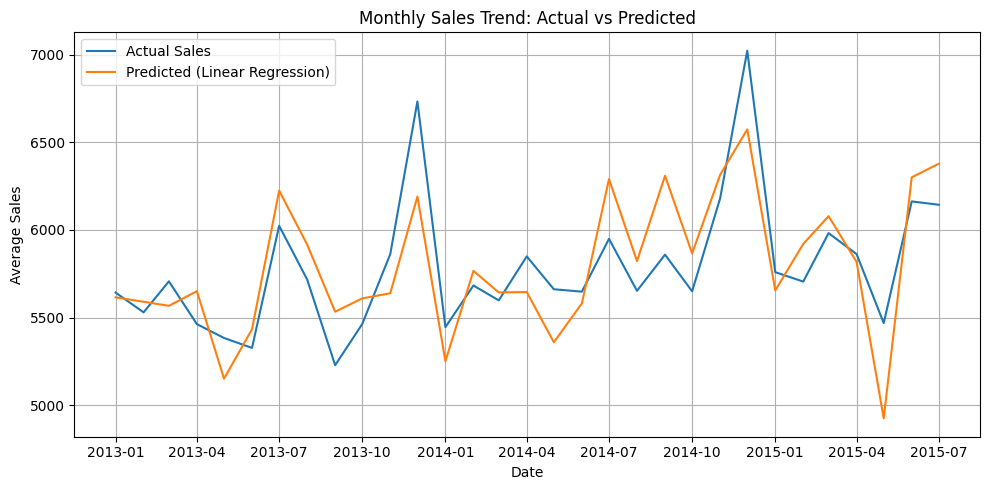

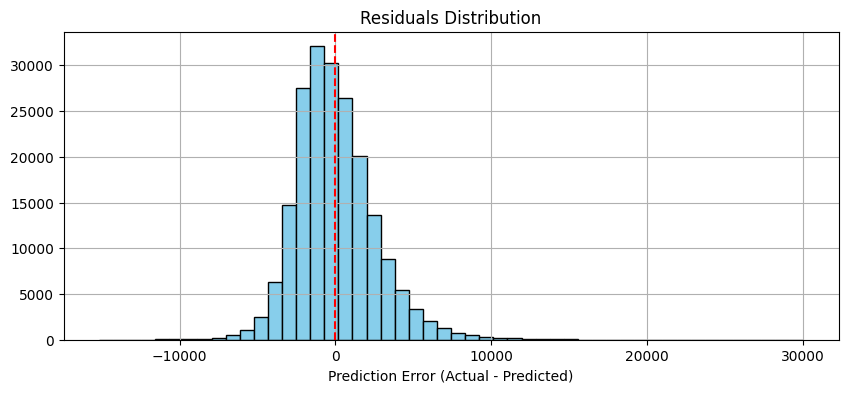

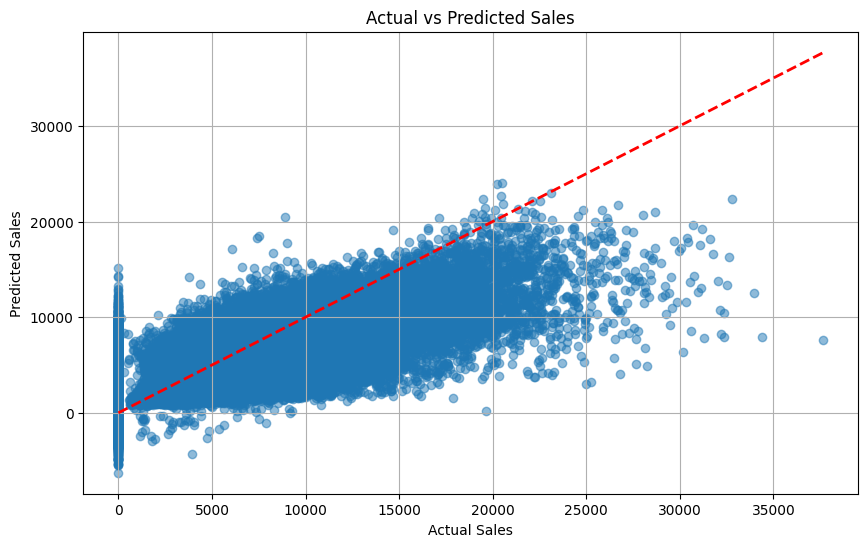


모델 성능 평가:
MAE: 1950.23
MSE: 6654834.54
RMSE: 2579.70
MAPE: 195819879671455481856.00%
R²: 0.5504


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 예측값과 실제값 저장
results_df = pd.DataFrame({
    'Actual': y_val.reset_index(drop=True),
    'Predicted': y_val_pred
})

# 파일 저장
results_df.to_csv("linear_regression_predictions.csv", index=False)
print("파일 저장 완료: linear_regression_predictions.csv")

# 예측 결과 불러오기
df = pd.read_csv("linear_regression_predictions.csv")

# R² 점수 계산
r2 = r2_score(df['Actual'], df['Predicted'])
print(f" R-squared (R²): {r2:.4f}")

# 훈련 데이터에서 날짜 정보 복원
df['Date'] = train_store.loc[X_val.index, 'Date'].reset_index(drop=True)

# 날짜 형식 변환
df['Date'] = pd.to_datetime(df['Date'])

# 월 단위로 집계
df['Month'] = df['Date'].dt.to_period('M').dt.to_timestamp()
monthly = df.groupby('Month')[['Actual', 'Predicted']].mean().reset_index()

# 월별 추세 시각화
plt.figure(figsize=(10, 5))
plt.plot(monthly['Month'], monthly['Actual'], label='Actual Sales')
plt.plot(monthly['Month'], monthly['Predicted'], label='Predicted (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.title('Monthly Sales Trend: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('monthly_sales_trend.png')
plt.show()

# 잔차 분포 시각화
residuals = df['Actual'] - df['Predicted']
plt.figure(figsize=(10, 4))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title("Residuals Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.axvline(0, color='red', linestyle='--')
plt.grid(True)
plt.savefig('residuals_distribution.png')
plt.show()

# 예측 vs 실제 산점도
plt.figure(figsize=(10, 6))
plt.scatter(df['Actual'], df['Predicted'], alpha=0.5)
plt.plot([df['Actual'].min(), df['Actual'].max()],
         [df['Actual'].min(), df['Actual'].max()],
         'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()

# 성능 지표 출력
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(df['Actual'], df['Predicted'])
mse = mean_squared_error(df['Actual'], df['Predicted'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(df['Actual'], df['Predicted']) * 100

print("\n모델 성능 평가:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

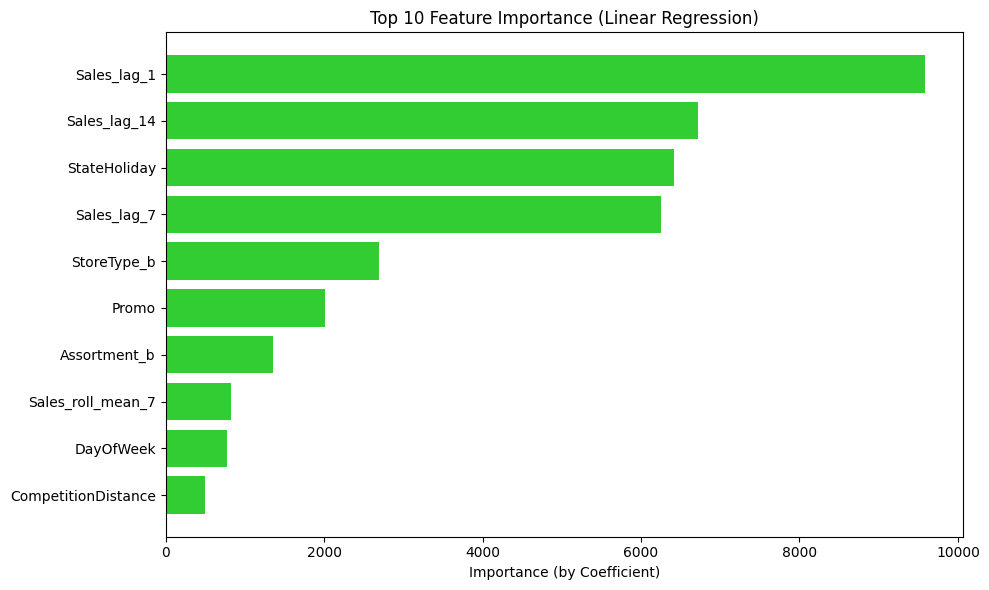

In [21]:
# 중요도 시각화
importance = best_model.coef_  # Use coefficients for Linear Regression

importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Get feature names from X_train
    'Importance': np.abs(importance)  # Use absolute values of coefficients
}).sort_values(by='Importance', ascending=False)

# 상위 10개 특성만 선택
top_10_importance_df = importance_df.head(10)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(top_10_importance_df['Feature'], top_10_importance_df['Importance'], color='limegreen')
plt.gca().invert_yaxis()
plt.xlabel("Importance (by Coefficient)")  # Update label
plt.title("Top 10 Feature Importance (Linear Regression)")  # Update title
plt.tight_layout()
plt.show()


### 선형 회귀 모델에 영향을 미치는 변수의 중요도

In [22]:

# 선형 회귀 모델에 영향을 미치는 변수의 중요도 확인
coeff_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': best_model.coef_.flatten()  # .flatten()을 사용하여 1D 배열로 변환
})

# 계수의 절대값을 기준으로 내림차순 정렬
coeff_df['abs_coefficient'] = coeff_df['coefficient'].abs()
coeff_df_sorted = coeff_df.sort_values(by='abs_coefficient', ascending=False)

# 변수의 영향력을 확인
print(coeff_df_sorted.round())

                feature  coefficient  abs_coefficient
6           Sales_lag_1       9589.0           9589.0
8          Sales_lag_14       6720.0           6720.0
2          StateHoliday      -6422.0           6422.0
7           Sales_lag_7       6257.0           6257.0
13          StoreType_b       2697.0           2697.0
1                 Promo       2007.0           2007.0
16         Assortment_b      -1352.0           1352.0
9     Sales_roll_mean_7       -831.0            831.0
0             DayOfWeek       -770.0            770.0
5   CompetitionDistance       -501.0            501.0
17         Assortment_c        318.0            318.0
4                Promo2       -269.0            269.0
3         SchoolHoliday        124.0            124.0
12                 Year         71.0             71.0
15          StoreType_d        -65.0             65.0
14          StoreType_c        -34.0             34.0
11                Month         29.0             29.0
10                  Day     

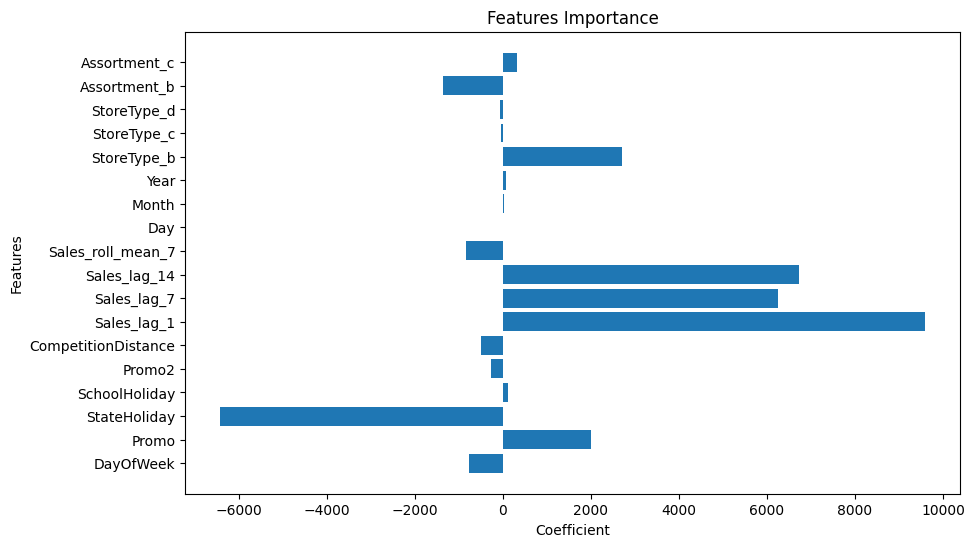

In [23]:
# 변수 영향력 시각화
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, best_model.coef_.flatten())
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title('Features Importance')
plt.show()

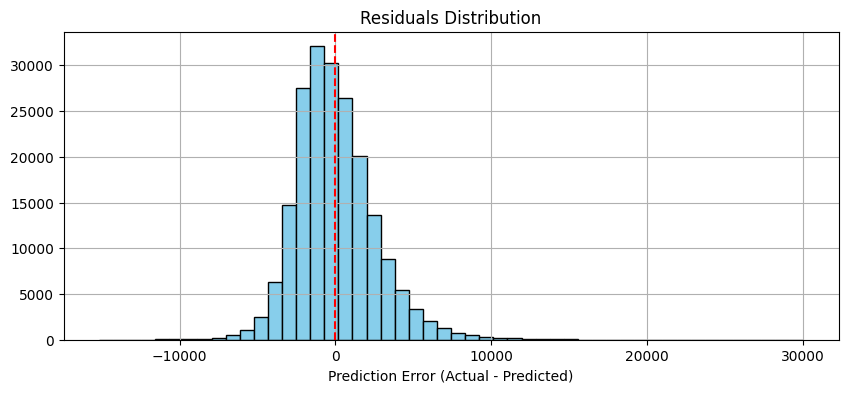

Statistic: 1456.8658761031984
Anderson-Darling: At 15.0% significance level, 데이터는 정규 분포를 따르지 않습니다.
Anderson-Darling: At 10.0% significance level, 데이터는 정규 분포를 따르지 않습니다.
Anderson-Darling: At 5.0% significance level, 데이터는 정규 분포를 따르지 않습니다.
Anderson-Darling: At 2.5% significance level, 데이터는 정규 분포를 따르지 않습니다.
Anderson-Darling: At 1.0% significance level, 데이터는 정규 분포를 따르지 않습니다.
Agostino Pearson검정: 34415.07339131835, p-value: 0.0
데이터는 정규 분포를 따르지 않습니다.


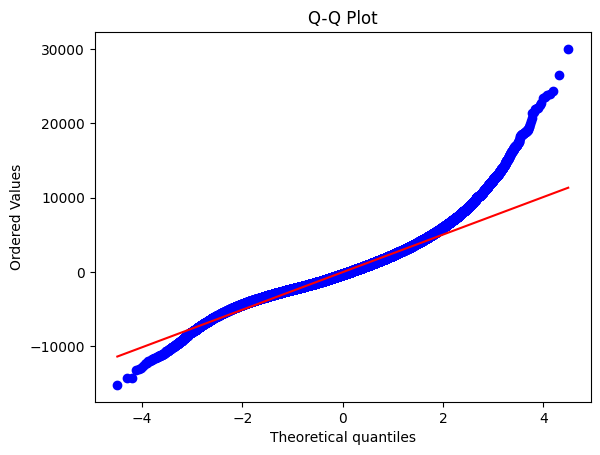

In [24]:
import numpy as np
from scipy.stats import shapiro

# 잔차 분포 시각화
residuals = df['Actual'] - df['Predicted']
plt.figure(figsize=(10, 4))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title("Residuals Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.axvline(0, color='red', linestyle='--')
plt.grid(True)
plt.savefig('residuals_distribution.png')
plt.show()

#2. Anderson-Darling 검정: 이 검정은 Kolmogorov-Smirnov 검정의 개선된 버전으로, 분포의 꼬리 부분에 더 민감합니다. 파이썬의 scipy.stats 모듈에서 anderson() 함수를 사용하여 수행할 수 있습니다.​

from scipy.stats import anderson

result = anderson(residuals)
print(f"Statistic: {result.statistic}")

for i in range(len(result.critical_values)):
    significance_level, critical_value = result.significance_level[i], result.critical_values[i]
    if result.statistic < critical_value:
        print(f"Anderson-Darling: At {significance_level}% significance level, 데이터는 정규 분포를 따릅니다.")
    else:
        print(f"Anderson-Darling: At {significance_level}% significance level, 데이터는 정규 분포를 따르지 않습니다.")

#3.D'Agostino 및 Pearson의 합동 정규성 검정:
from scipy.stats import normaltest

stat, p_value = normaltest(residuals)
print(f"Agostino Pearson검정: {stat}, p-value: {p_value}")
if p_value > 0.05:
    print(" 데이터는 정규 분포를 따릅니다.")
else:
    print("데이터는 정규 분포를 따르지 않습니다.")

import matplotlib.pyplot as plt
from scipy.stats import probplot

probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

